In [3]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# this makes the random number generation reproducable: 
np.random.seed(seed=9)

In [4]:
NE0=250 # number of cells in horizontal direction
NE1=250 # number of cells in vertical direction
h0=300. # in horizontal meter [m] grid spacing
h1=300. # in vertical meter [m] grid spacing


In [5]:
L0, L1=NE0*h0, NE1*h1

In [6]:
from esys.escript import *
from esys.finley import Rectangle
domain=Rectangle(l0=L0, l1=L1, n0=NE0, n1=NE1)

True density distribution:

In [7]:
rho1=-2000
rho2=1500

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
X=ReducedFunction(domain).getX()
m1=whereNegative(length(X-[L0*0.4,L1*0.35])-L0*0.05)
m2=whereNegative(length(X-[L0*0.6,L1*0.45])-L0*0.05)
rho_true=m1*rho1+m2*rho2

Text(0, 0.5, '$x_1$ [m]')

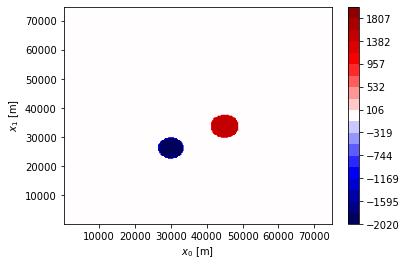

In [9]:
rho_np=convertToNumpy(rho_true) 
X_np=convertToNumpy(X)

plt.figure()
vmax=abs(rho_np).max()*1.01
contour=plt.tricontourf(X_np[0], X_np[1], rho_np[0], levels=np.linspace(-vmax,vmax,20), cmap='seismic')
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')


Mask for where we test the data (=`Wd`):

In [10]:
H_data=0.65*L1

In [11]:
surface_z=int(H_data/h1)*h1
surface_z+h1/2,L1

(48750.0, 75000.0)

In [12]:
m_data=whereNegative(abs(X[1]-(surface_z+h1/2))-h1/2)*whereNegative(abs(X[0]-L0/2)-L0*0.3)


Text(0, 0.5, '$x_1$ [m]')

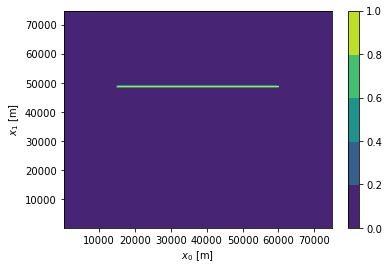

In [13]:
plt.figure()
contour=plt.tricontourf(X_np[0], X_np[1], convertToNumpy(m_data)[0], 5)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')


In [14]:
from mytools import getGravity, Inversion2DGravity, mGal

ModuleNotFoundError: No module named 'mytools'

Get the test data and add some noise:

In [ ]:
data=getGravity(domain, rho_true)

In [ ]:
data*=(1+0.10*(2*RandomData((), data.getFunctionSpace())-1))

 set `Wd`:

In [ ]:
Wd=interpolate(m_data, Function(domain))
Wd/=integrate(Wd)
Wd*=1/abs(0.10*data)**2


Define the cost function:

In [ ]:
cf=Inversion2DGravity(domain, data, Wd, z_surface=surface_z, rhodash=1, mu=1.e-6)

Run inversion:

In [ ]:
from esys.downunder import MinimizerLBFGS
solver=MinimizerLBFGS(J=cf, m_tol=1e-3, J_tol=None, imax=500)
solver.setOptions(interpolationOrder=1, truncation=25, restart=60)
m=Scalar(0., Solution(domain))
solver.run(m)
mi=solver.getResult()

An plot the result:

In [ ]:
rho=mi*cf.rhodash+cf.rho_ref
rho_np=convertToNumpy(rho)
x_np=convertToNumpy(rho.getX())
plt.figure()
vmax=abs(rho_np).max()*1.01
contour=plt.tricontourf(x_np[0], x_np[1], rho_np[0], levels=np.linspace(-vmax,vmax,20), cmap='seismic')
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

Plot the data and recovered data:

In [ ]:
from esys.escript.pdetools import Locator
x0_transect=np.linspace(h0/2, L0-h0/2, NE0)
x_transect=[ (x0, surface_z+h1/2) for x0 in np.linspace(L0/2-L0*0.3, L0/2+L0*0.3, int(NE0*0.6)) ]
transect_locator=Locator(where=ReducedFunction(domain), x=x_transect )
x0_transect=[ x[0] for x in transect_locator.getX() ]

In [ ]:
data_transect=transect_locator.getValue(data*mGal)

In [ ]:
datai=getGravity(domain, rho)
datai_transect=transect_locator.getValue(datai*mGal)

In [ ]:
plt.figure()
plt.scatter(x0_transect, data_transect, label="input", s=1)
plt.plot(x0_transect, datai_transect, label="recovered")
plt.xlabel('offset [m]')
plt.ylabel('$g_z$ [mGal]')
plt.legend()
plt.title("gravity anomaly over transect @ height %g m"%(transect_locator.getX()[0][1]))